# Model Testing

There are three models for ...

## Data Processing

We'll be using the [NPInter v4.0](http://bigdata.ibp.ac.cn/npinter4) database for RNA-Protein interactions. There were gathered by downloading the [All Interactions](http://bigdata.ibp.ac.cn/npinter4/download/file/interaction_NPInterv4.txt.gz) in NPInter.

In [41]:
import pandas as pd
import requests
from io import StringIO
from gzip import GzipFile

import matplotlib.pyplot as plt
import seaborn as sbn; sbn.set()

import torch
from torch import nn

In [51]:
# Get and open NPInter data
url = "http://bigdata.ibp.ac.cn/npinter4/download/file/interaction_NPInterv4.txt.gz"
data = requests.get(url).content

df = pd.read_csv(BytesIO(data), compression='gzip', sep = '\t')

del data

# Filter out non-RPI interactions. 
rpi_expermient = df.level.isin(['RNA-Protein','RNA-TF','lncRNA-TF','ncRNA-TF'])
protein_target = df.tarType == 'protein'
rna_source     = df.ncType  != 'protein'
rpi_binding    = df['class'] == 'binding'

# Filter out RNAs or Proteins with a blank ID
has_rna_id     = df.ncID != '-'
has_protein_id = df.tarID != '-'

# Remove purely in-silico experiments
not_in_silico = ~df.experiment.isin(['Bioinformatics', 'TargetScan and MiRanda prediction algorithms',
                                      'Statistical analysis', 'prediction', 'Statistical analyses',
                                      'statistical analysis', "Correlation and co-expression analysis"])

df = df[rpi_expermient & protein_target & rna_source & rpi_binding # Filter out non-RPI interactions
        & has_rna_id & has_protein_id                              # Filter out RNAs or Proteins with a blank ID
        & not_in_silico]                                           # Remove purely in-silico experiments

print(f"""
There are: {df.shape[0]} interactions
---
""")

df.head()


There are: 457498 interactions
---



,interID,ncName,ncID,ncType,tarName,tarID,tarType,interDescription,experiment,reference,organism,tissueOrCell,tag,class,level,datasource
0,ncRI-40000001,4.5S,NONOTHNOBEDT000074,lncRNA,rpoD,P0A6M8,protein,"Following translocation, 4.5S RNA replaces 23S...",Immunoprecipitation experiments;EMSA;SDS-polya...,8662727;8107852;1281314,Escherichia coli,-,ncRNA-protein binding,binding,RNA-Protein,Literature mining
1,ncRI-40000002,6S,NONOTHNOBEDT000078,lncRNA,rpoB,M1FYN7,protein,UV crosslinking experiments revealed that 6S R...,cross-linking,10892648,Escherichia coli,-,ncRNA-protein binding,binding,RNA-Protein,Literature mining
2,ncRI-40000003,6S,NONOTHNOBEDT000078,lncRNA,rpoD,P00579,protein,The stable association of sigma70 with core en...,cross-linking,10892648,Escherichia coli,-,ncRNA-protein binding,binding,RNA-Protein,Literature mining
5,ncRI-40000006,7SK,NONHSAG040596,lncRNA,HEXIM1,O94992,protein,Binding of the 7SK snRNA turns the HEXIM1 prot...,Yeast two-hybrid analysis;Immunofluorescence;M...,15201869;15994294;17671421;20675720;20926576;1...,Homo sapiens,-,ncRNA-protein binding,binding,RNA-Protein,Literature mining
7,ncRI-40000008,7SK,NONHSAG040596,lncRNA,Tat,P17735,protein,Tat efficiently replaces HEXIM1 on the 7SK snR...,-,20976203;20471949,Homo sapiens,-,ncRNA-protein binding,binding,RNA-Protein,Literature mining


In [52]:
print(f"There are {len(set(df2.tarID))} unique proteins")
print(f"There are {len(set(df2.ncID))} unique RNAs")

######################################################
# Next cell is distribution of protein and rna lengths,
# fill in when you acquire this info
######################################################

There are 1005 unique proteins
There are 76226 unique RNAs


In [4]:
# # Protein length distribution for training
# # RNA length distribution for training

# fig, axes = plt.subplots(2,1, figsize = (8,5),
#                          constrained_layout=True)

# axes[0].hist(length_dict['protein'], bins=100,
#              color = 'mediumslateblue',
#              edgecolor='black')
# axes[0].set_title('Training Protein length distribution')
# axes[0].set_ylabel('Frequency')
# axes[0].set_yscale('log')
# axes[0].set_xlabel('Residues')

# axes[1].hist(length_dict['rna'], bins=100,
#              color = 'lightgreen',
#              edgecolor='black')
# axes[1].set_title('Training RNA length distribution')
# axes[1].set_ylabel('Frequency')
# axes[1].set_yscale('log')
# axes[1].set_xlabel('Nucleotides')
# #axes[1].set_ylim(0,10**3+1)

# sbn.despine()

In [53]:
# Count how many times an RPI occurs for each unique RNA and how many times it occures for each protein
# Circos-esque graph

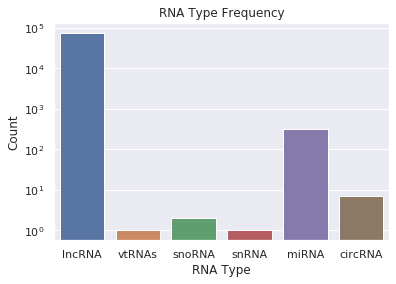

In [77]:
#############################################################
# Frequency of each RNA type
#############################################################

unique_rna_df = df.groupby(['ncID','ncType']).size().reset_index()

sbn.countplot('ncType', data = unique_rna_df)

plt.title("RNA Type Frequency")
plt.yscale('log')
plt.xlabel('RNA Type')
plt.ylabel('Count');

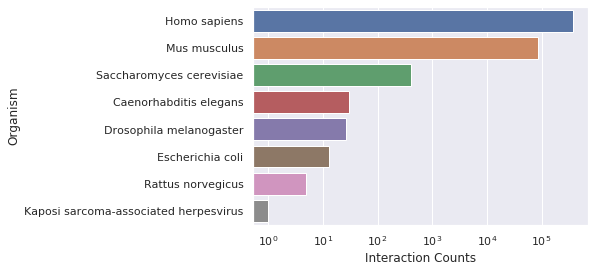

In [78]:
##############################################
# Number of interactions for each organism
##############################################

sbn.countplot(y = 'organism',
              data = df,
              order = df['organism'].value_counts().index,
              dodge = False)

plt.ylabel('Organism')
plt.xlabel('Interaction Counts')
plt.xscale('log')

In [81]:
##############################################
# Experiment Type
##############################################

df['experiment'].value_counts()

eCLIP                                                                                                     128022
CLIP-Seq                                                                                                  111568
PAR-CLIP                                                                                                   74695
CLIP                                                                                                       61503
HITS-CLIP                                                                                                  41165
HITS-CLIP;CLIP-Seq                                                                                         18605
eCLIP;CLIP                                                                                                  6100
iCLIP                                                                                                       4704
CLIP;PAR-CLIP                                                                                   

In [80]:
# Make another plot representing organism cell type if applicable to otganism
# Reduce each category to one cell type
# sbn.countplot(y = 'tissueOrCell',
#               data = df2,
#               order = df2['tissueOrCell'].value_counts().index,
#               dodge = False)

df['tissueOrCell'].value_counts()

HEK293                                                                70385
HepG2                                                                 52620
K562                                                                  51905
HeLa                                                                  38442
MDA-MB-231                                                            33982
mouse brain                                                           30824
human brain                                                           27927
HepG2;K562                                                            22627
mouse brain;cerebrums                                                 18035
ESC                                                                   15818
Flp-In 293                                                             8552
HEK293T                                                                7589
C666                                                                   6101
MDA-LM2     

## Predict Interactions Using Whole RNA Sequence

There are three models that are predicted using 

|PMID|Title|Model name|Type|
|:--:|:--:|:--:|:--:|
31151273|A Hybrid Prediction Method for Plant lncRNA-Protein Interaction|PLRPIM|Protein and RNA Autoencoders -> LGBM RF|
31890140|Learning distributed representations of RNA and protein sequences and its application for predicting lncRNA-protein interactions|LPI-Pred|Embedding -> RF classifier|
30832218| RPITER: A Hierarchical Deep Learning Framework for ncRNA Protein Interaction Prediction| RPITER| Wide CNN + SAE ensemble -> 2 Dense -> output| 
30813451| BGFE: A Deep Learning Model for ncRNA-Protein Interaction Predictions Based on Improved Sequence Information | BGFE | Protein and RNA SAEs -> RF|
30321541 | Prediction of RNA-protein interactions by combining deep convolutional neural network with feature selection ensemble method | RPIFSE | Deeper CNN -> dense -> output ->  ELM|
27506469| IPMiner: hidden ncRNA-protein interaction sequential pattern mining with stacked autoencoder for accurate computational prediction | IPMiner | SAE -> RF -> Log. Regression |
29858068 | A Deep Learning Framework for Robust and Accurate Prediction of ncRNA-Protein Interactions Using Evolutionary Information | RPI-SAN | SAE -> RF |

These tools are also compared using three precurated datasets frequently used for comparison:

| Dataset | Positive IDs | Negative IDs | RNAs | Proteins | Organisms | Ref |
-------|----|------|----|-------|----|---
RPI1807 | 1807 | 1436 | 1078 | 3131 | X | [[3]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4330382/pdf/gkv020.pdf) |
RPI2241 | 2241 | 2241 | 841 | 2042 | X | [[1]](https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-12-489) |


## Predict Binding From RNA/DNA

Below are the architectures designed to predict RNA/DNA binding motifs found within their respective sequences. However, because this is the same base problem, we can apply it to RNA sequences. below are the architectures found that predict binding sites within RNA/DNA sequences:

|PMID|Title|Name|Architecture/Type|
|:--:|:--:|:--:|:--:|
31824574| CircSLNN: Identifying RBP-Binding Sites on circRNAs via Sequence Labeling Neural Networks | CircSLNN | CNN -> BiLSTM -> Conditional Random Field |
31537716 | CRIP: predicting circRNA-RBP-binding sites using a codon-based encoding and hybrid deep neural networks | CRIP | CNN -> Bidirrectional LSTM -> 2 Dense |
31323206 | Prediction of the RBP binding sites on lncRNAs using the high-order nucleotide encoding convolutional neural network | HOCNNLB | CNN -> Max Pooling -> 2 Dense layers -> softmax | 
28245811 | RNA-protein binding motifs mining with a new hybrid deep learning based cross-domain knowledge integration approach | iDeep | Hybrid CNN-DBN |
31562101 | Capsule Network for Predicting RNA-Protein Binding Preferences Using Hybrid Feature | iCapsule | Capsule network |
31483777 | Integrating thermodynamic and sequence contexts improves protein-RNA binding prediction | ThermoNet | Parallel conv -> ??? | 
31026297 | Prediction of binding property of RNA-binding proteins using multi-sized filters and multi-modal deep convolutional neural network | mmCNN | CNN |
30990191 | RNA-Protein Binding Sites Prediction via Multi Scale Convolutional Gated Recurrent Unit Networks | MSCGRU |	Multiscale CNN -> biGRU -> dense -> output |
30423078 | A deep neural network approach for learning intrinsic protein-RNA binding preferences | DLPRB | parallel CNN and bidirrectional GRU/LSTM |
29970003 | Prediction of RNA-protein sequence and structure binding preferences using deep convolutional and recurrent neural networks | iDeepS | parallel (conv_filters -> maxpooling) x n -> combined bidirrectionalLSTM |
29722865 | Predicting RNA-protein binding sites and motifs through combining local and global deep convolutional neural networks | iDeepE | Parallel (global/local CNNs ->  max pooling -> dense x 2)  -> output |
26467480 | A deep learning framework for modeling structural features of RNA-binding protein targets | Deepnet-rbp |	Parallel encoded inputs of input embeddings |


|PMID|Title|Name|Architecture/Type|
|:--:|:--:|:--:|:--:|
31372637 | Prediction of regulatory motifs from human Chip-sequencing data using a deep learning framework| DESSO | Conv Layer -> Max pooling -> Dense layer |
31161194|MTTFsite: cross-cell type TF binding site prediction by using multi-task learning | MTTFste | private and shared CNNs for multitask learning |
30922998 | FactorNet: A deep learning framework for predicting cell type specific transcription factor binding from nucleotide-resolution sequential data | FactorNet | CNN -> Dense -> Max pooling -> LSTM -> dense (linear) -> dense(sigmoid) -> dense(softmax)|
29757349 | Base-pair resolution detection of transcription factor binding site by deep deconvolutional network | DeepSNR | Conv layer -> max pooling -> dense -> dense -> Max unpooling -> Deconvolutional layer -> maxpooling -> output (Sigmoid) |
26213851 | Predicting the sequence specificities of DNA- and RNA-binding proteins by deep learning | DeepBind | Conv layer -> max pool -> output |
32551184 | DeeperBind: Enhancing Prediction of Sequence Specificities of DNA Binding Proteins | DeeperBind | Conv layer -> (unidirrectionsl LSTM) x 2 -> Dense -> output |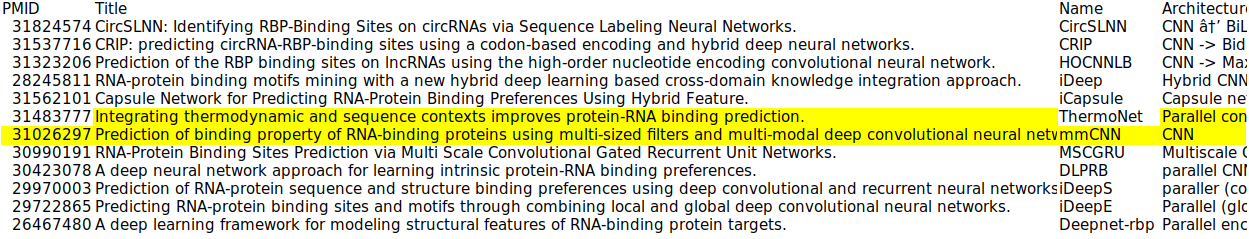

## Predict Binding From Protein